# Water balance calculation

- **Main ideas:**
    - This notebook is intended for constructing `daily` water balance variable, which is defined as the difference between daily precipitation and evapotranspiration. 
    - Total precipitation and evaporation are both at `12-hour` resolution, from 1979-01-01 to 2018-12-31. The spatial coverage is global with 0.75x0.75 degrees resolution. We export resulting water balance files in the same spatial grid with `daily` time resolution.    
    - First we create a variable called water balance ($WB$) which is based on the difference between total precipitation ($TP$) and evaporation ($E$):
    $$
    WB = TP - E
    $$
    - Please note the fliped sign in evaporation on the above cell.This is so because of ERA interim definition of evaporation, as you can see in [evaporation parameter details](https://apps.ecmwf.int/codes/grib/param-db?id=182). Also, remember that evaporation is the accumulated amount of water that has evaporated from the Earth's surface, **including a simplified representation of transpiration (from vegetation)**, into vapour in the air above.    

# Initial setup

In [1]:
%%time

# Load packages.
import sys
import importlib
import glob
import calendar
import datetime
import progressbar
import os

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

from dask.diagnostics import ProgressBar

xr.set_options(display_style="text")

# Figures inside this notebook.
%matplotlib inline

CPU times: user 1.21 s, sys: 197 ms, total: 1.4 s
Wall time: 2 s


In [2]:
# My repository.
repository = "/home/alex/Dropbox/repositories/cdlearn/"

In [3]:
%%time

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my libraries.
import cdlearn

CPU times: user 1.84 s, sys: 249 ms, total: 2.09 s
Wall time: 2.97 s


In [4]:
# Data folder.
MAIN_FOLDER = "/media/alex/ALEXDATA/data_sets/ERA_INTERIM/"

## Read total precipitation data

In [5]:
# Data folder.
FOLDER_TP = MAIN_FOLDER + "total_precipitation_daily/"

# Absolute files paths. Only grib extensions.
FILES_PATHS_TP = sorted(glob.glob(FOLDER_TP + "*nc"))

print("Number of files:", len(FILES_PATHS_TP))

Number of files: 480


In [6]:
%%time

# Read data using xarray package.
DS_TP = xr.open_mfdataset(
    paths=FILES_PATHS_TP,
    concat_dim="time",
    combine="nested",
    chunks={}
)

# Guarantee time ordering.
DS_TP = DS_TP.sortby("time")

# Show it.
print(DS_TP)

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 29220)
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2019-01-01
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(62, 241, 480), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-02-28 01:13:28 GMT by grib_to_netcdf-2.12.0: grib_to_n...
CPU times: user 13.6 s, sys: 2.49 s, total: 16.1 s
Wall time: 1min 20s


## Read total evaporation

In [7]:
# Data folder.
FOLDER_E = MAIN_FOLDER + "evaporation_daily/"

# Absolute files paths. Only grib extensions.
FILES_PATHS_E = sorted(glob.glob(FOLDER_E + "*grb"))

print("Number of files:", len(FILES_PATHS_E))

Number of files: 480


In [8]:
%%time

# Read data using xarray package.
DS_E = xr.open_mfdataset(
    paths=FILES_PATHS_E,
    concat_dim="time",
    combine="nested",
    engine="cfgrib",
    chunks={}
)

# Guarantee time ordering.
DS_E = DS_E.sortby("time")

# Show it.
print(DS_E)

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 29220)
Coordinates:
    number      int64 0
    surface     int64 0
    step        timedelta64[ns] 12:00:00
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * time        (time) datetime64[ns] 1979-01-01 ... 2018-12-31T12:00:00
    valid_time  (time) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
Data variables:
    e           (time, latitude, longitude) float32 dask.array<chunksize=(62, 241, 480), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-08-05T18:28:40 GRIB to CDM+CF via cfgrib-0....
C

## Calculate daily water balance

**Lazy operations!**

In [9]:
%time

# Daily total precipitation.
DS_TP_DA = DS_TP.resample({"time": "1D"}).sum("time")

# Guarantee time order.
DS_TP_DA = DS_TP_DA.sortby(DS_TP_DA.time)

# Daily evaporation.
DS_E_DA = DS_E.resample({"time": "1D"}).sum("time")

# Guarantee time order.
DS_E_DA = DS_E_DA.sortby(DS_E_DA.time)

# Align both data sets.
DS_TP_DA, DS_E_DA = xr.align(DS_TP_DA, DS_E_DA)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [10]:
%%time

# Create water balance variable as a xarray DataSet object. 
DS_WB_DA = DS_TP_DA + DS_E_DA # Evaporation is negetive! DataSet without variables.
    
# Create the corresponding variable with some attributes.
DS_WB_DA = DS_WB_DA.assign(variables={"wb": DS_TP_DA.tp + DS_E_DA.e})
DS_WB_DA.wb.attrs["calculation"] = "Made by Alex Araujo at " + \
                                    datetime.datetime.now().strftime("%Y-%m-%d")
DS_WB_DA.wb.attrs["long_name"] = "Water balance"
DS_WB_DA.wb.attrs["units"] = "m"

# Show it. 
print(DS_WB_DA.wb)

<xarray.DataArray 'wb' (time: 14610, latitude: 241, longitude: 480)>
dask.array<add, shape=(14610, 241, 480), dtype=float32, chunksize=(1, 241, 480), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
    number     int64 0
    surface    int64 0
    step       timedelta64[ns] 12:00:00
Attributes:
    calculation:  Made by Alex Araujo at 2020-08-05
    long_name:    Water balance
    units:        m
CPU times: user 93 ms, sys: 3.84 ms, total: 96.8 ms
Wall time: 96 ms


## Exporting water balance data as netcdf files

**This is done just once and it takes about two hours in the first time. Lazy operations.**

In [11]:
# Pandas date times.
dates = pd.to_datetime(DS_WB_DA.time.values)

# Range of dates. 
years = dates.year.unique()
months = dates.month.unique()
number_of_iterations = years.size * months.size

# Where data will be put.
data_path = "/media/alex/ALEXDATA/data_sets/ERA_INTERIM/water_balance_daily/"

# Root for file name.
root = "wb_"

# Loop over each month in each year.
with progressbar.ProgressBar(max_value=number_of_iterations) as p:
    index = 0
    for year in years:
        for month in months:
    
            # Data file.
            file_path = data_path + root + "{0:04d}_{1:02d}.nc".format(year, month)
    
            # Continue only if data file does not exist yet.
            if not os.path.isfile(file_path):
    
                # Select data corresponding to this date.
                DATASET = DS_WB_DA.sel(time=str(year) + "-" + str(month))
            
                # Export selected data as a netcdf file.
                DATASET.to_netcdf(file_path)
            
            index += 1
            p.update(index)

100% (480 of 480) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


## Read water balance data

In [12]:
# Data folder.
FOLDER_WB = MAIN_FOLDER + "water_balance_daily/"

# Absolute files paths. Only netcdf extensions.
FILES_PATHS_WB = sorted(glob.glob(FOLDER_WB + "*nc"))

print("Number of files:", len(FILES_PATHS_WB))

Number of files: 480


In [13]:
%%time

# Read data using xarray package.
DS_WB = xr.open_mfdataset(
    paths=FILES_PATHS_WB,
    concat_dim="time",
    combine="nested",
    chunks={}
)

# Guarantee time ordering.
DS_WB = DS_WB.sortby("time")

# Show it.
print(DS_WB)

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 14610)
Coordinates:
    number     int64 0
    surface    int64 0
    step       timedelta64[ns] 12:00:00
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    wb         (time, latitude, longitude) float32 dask.array<chunksize=(31, 241, 480), meta=np.ndarray>
CPU times: user 11.9 s, sys: 406 ms, total: 12.3 s
Wall time: 15.3 s


In [14]:
%%time

# Group data by month and then calculate the mean. Load into memory!
DS_WB_mm = DS_WB.wb.groupby("time.month").mean("time").compute()

# Show it.
print(DS_WB_mm)

<xarray.DataArray 'wb' (month: 12, latitude: 241, longitude: 480)>
array([[[3.94410774e-04, 3.94410774e-04, 3.94410774e-04, ...,
         3.94410774e-04, 3.94410774e-04, 3.94410774e-04],
        [4.21926583e-04, 4.22136829e-04, 4.22334822e-04, ...,
         4.21526551e-04, 4.21725563e-04, 4.21789911e-04],
        [4.31314198e-04, 4.31885739e-04, 4.32440836e-04, ...,
         4.30151616e-04, 4.30493237e-04, 4.30830434e-04],
        ...,
        [6.61005397e-05, 6.60702135e-05, 6.61046506e-05, ...,
         6.67302957e-05, 6.65173065e-05, 6.63237806e-05],
        [8.35754836e-05, 8.37296611e-05, 8.39597269e-05, ...,
         8.36256877e-05, 8.36043619e-05, 8.35902902e-05],
        [8.60945802e-05, 8.60945802e-05, 8.60945802e-05, ...,
         8.60945802e-05, 8.60945802e-05, 8.60945802e-05]],

       [[3.26783047e-04, 3.26783047e-04, 3.26783047e-04, ...,
         3.26783047e-04, 3.26783047e-04, 3.26783047e-04],
        [3.50644084e-04, 3.50850343e-04, 3.51141003e-04, ...,
         3.50436

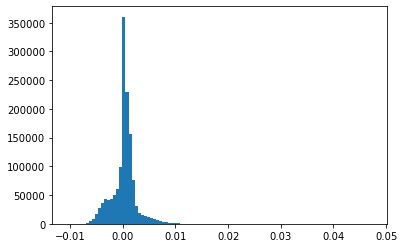

In [15]:
# Data distribution.
plt.hist(DS_WB_mm.values.flatten(), bins=100);

CPU times: user 21 s, sys: 36.7 ms, total: 21.1 s
Wall time: 21.2 s


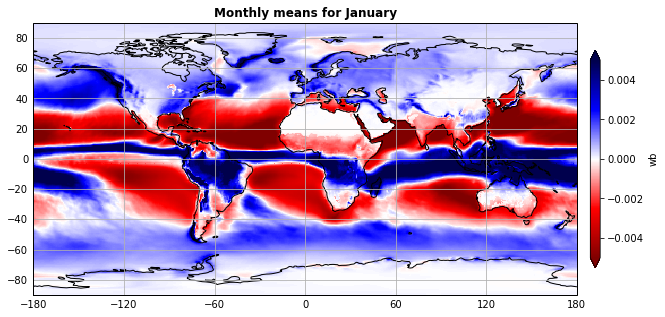

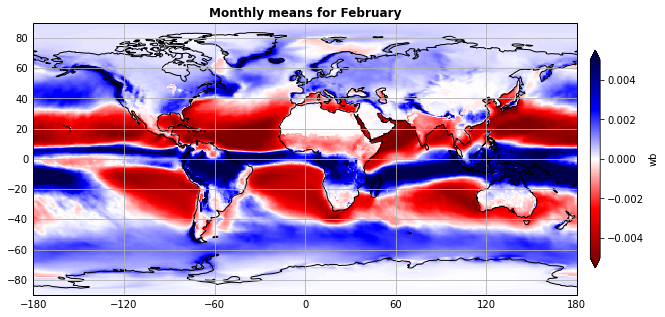

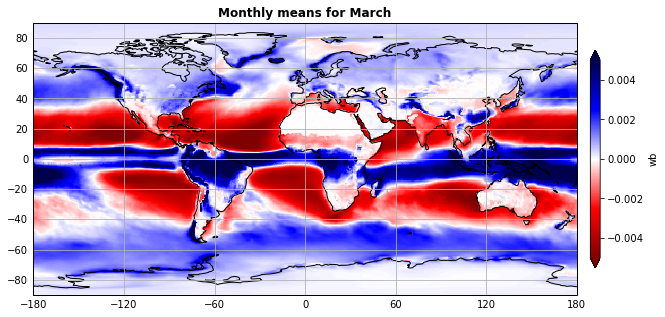

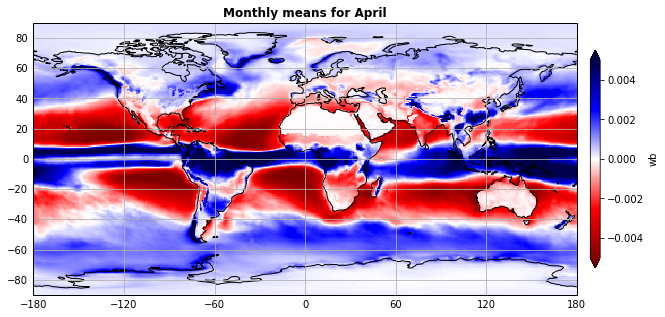

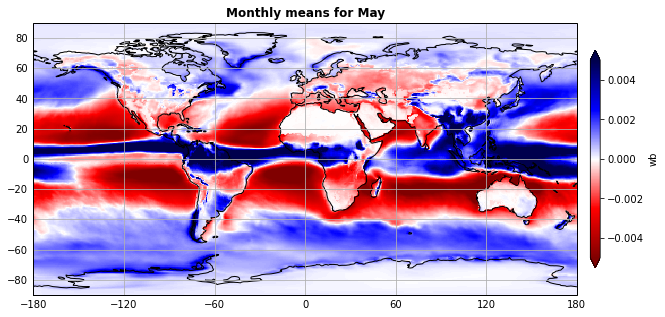

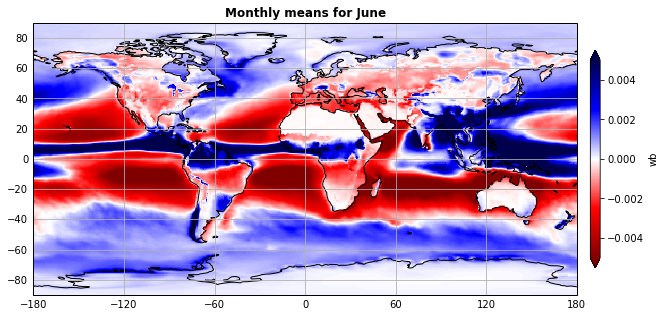

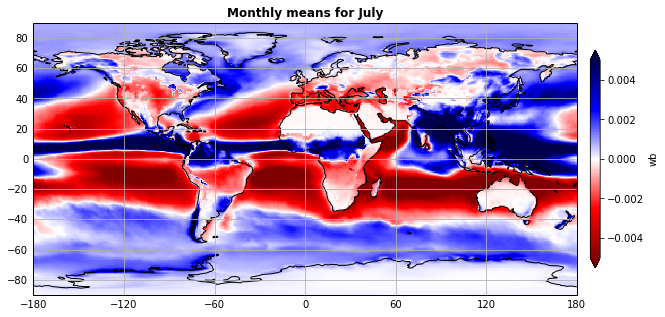

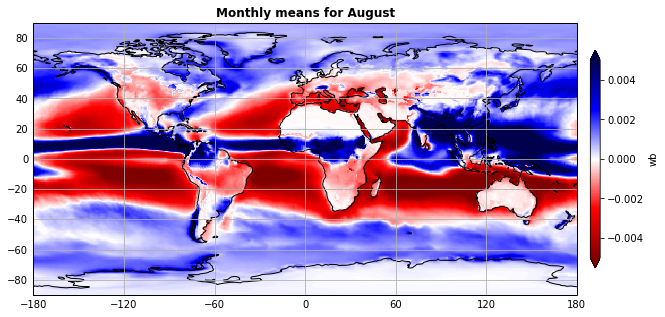

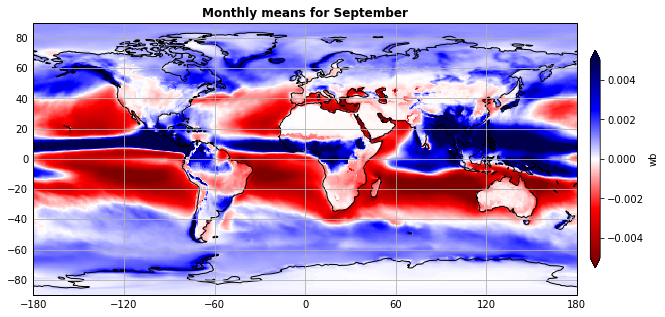

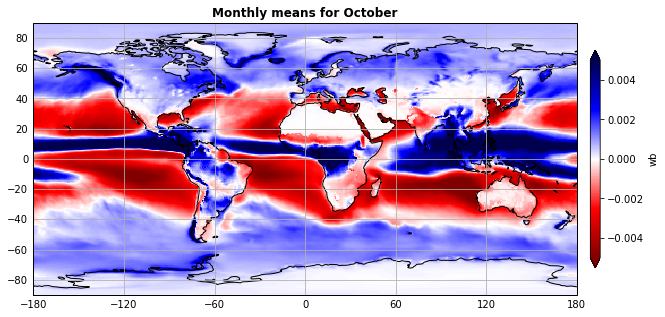

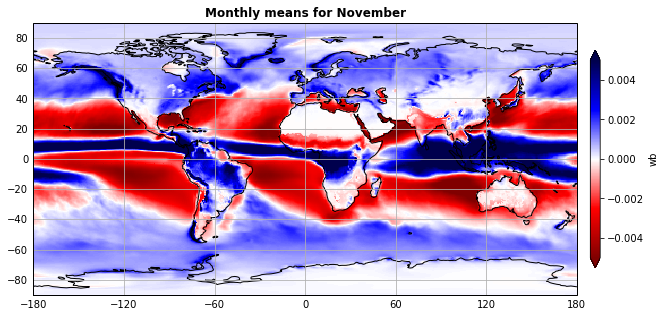

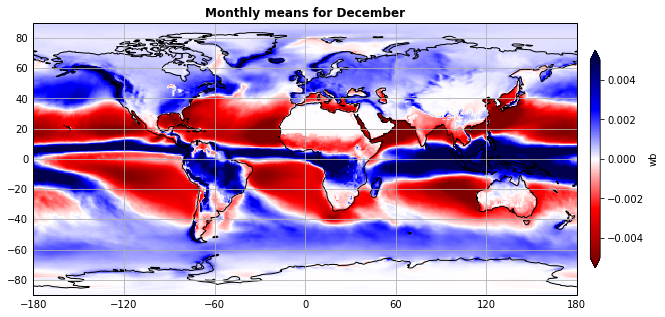

In [16]:
%%time

# Plot monthly means.
for month in range(1, 13):
    
    # Make map.
    fig = plt.figure(figsize=(12, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    mapa = DS_WB_mm.sel(month=month).plot(
        ax=ax, 
        vmin=-0.005, vmax=0.005,
        cmap=plt.cm.seismic_r, 
        cbar_kwargs={"shrink": 0.80,
                     "pad": 0.020,
                     "extend": "both"})
    ax.set_title("Monthly means for " + calendar.month_name[month], weight="bold");

## Time Series

In [17]:
# Select a pixel around Amazonia.
lon = 120; lat = -5

In [18]:
%%time

# Retrieve daily time series as pandas Series.
DS_WB_TS = DS_WB.wb.sel(longitude=lon, latitude=lat, method="nearest").load()

# Retrieve monthly time series.
DS_WB_TS_MM = DS_WB_TS.resample({"time": "1MS"}).mean("time")

CPU times: user 2.72 s, sys: 657 ms, total: 3.38 s
Wall time: 7.43 s


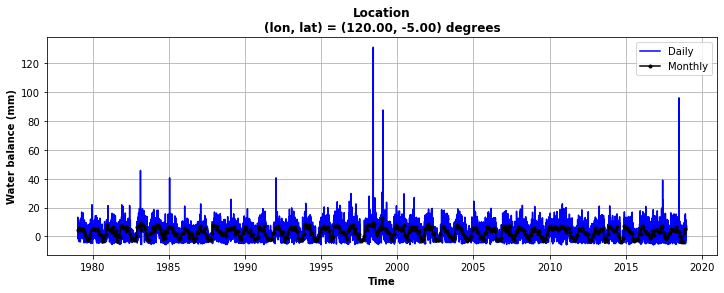

In [19]:
# Plot these time series.
plt.figure(figsize=(12, 4))
plt.plot(DS_WB_TS.time, DS_WB_TS.values * 1000, "-b", label="Daily")
plt.plot(DS_WB_TS_MM.time, DS_WB_TS_MM.values * 1000, ".-k", label="Monthly")
plt.xlabel("Time", weight="bold")
plt.ylabel("Water balance (mm)", weight="bold")
plt.title("Location\n(lon, lat) = (%.2f, %.2f) degrees" %(lon, lat), weight="bold")
plt.grid()
plt.legend();

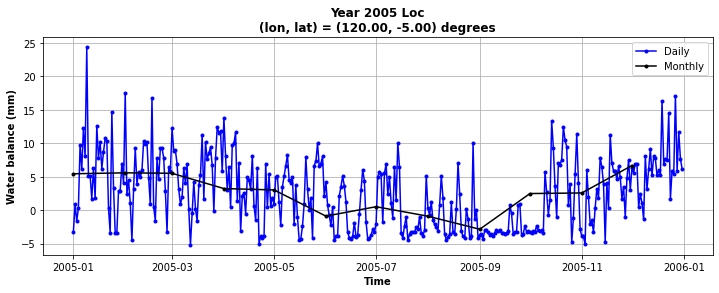

In [20]:
# The same as before, but just for one year.
year = "2005"
plt.figure(figsize=(12, 4))
plt.plot(DS_WB_TS.sel(time=year).time, DS_WB_TS.sel(time=year).values * 1000, 
         ".-b", label="Daily")
plt.plot(DS_WB_TS_MM.sel(time=year).time, DS_WB_TS_MM.sel(time=year).values * 1000, 
         ".-k", label="Monthly")
plt.xlabel("Time", weight="bold")
plt.ylabel("Water balance (mm)", weight="bold")
plt.title("Year %s Loc\n(lon, lat) = (%.2f, %.2f) degrees" %(year, lon, lat), weight="bold")
plt.grid()
plt.legend();